# Non-Negative Matrix Factorization (NMF)

This problem focuses on the practice of building NMF topic models, and also gives an opportunity to practice working with data wrangling and sparse matrix objects. At the bottom of this notebook, there's an opportunity to investigate some theory behind NMF, if you like.

## 1. Read in Data

First, we need to download the [data](http://mlg.ucd.ie/files/datasets/bbc.zip) into a `./bbc` folder in this directory. Then, we want to get the **terms** (*bbc.terms*), the **documents** (*bbc.docs*), and then the **term-document matrix** (*bbc.mtx*). These are news articles collected from 5 different topics, with the data already pre-processed into a document-term matrix (count vectorized). 

* *bbc.mtx* is a sparse document-term matrix file with a special format (*MatrixMarket*) that represents the count vectorization  
* *bbc.terms* is a list of words corresponding to the columns of the matrix 
* *bbc.docs* is a list of the article's actual topic designations

In [1]:
# Terms
with open('./bbc/bbc.terms') as f:
    content = f.readlines()
terms = [c.split()[0] for c in content]

# Docs
with open('./bbc/bbc.docs') as f:
    content = f.readlines()
docs = [c.split()[0] for c in content]

# Term-Doc Matrix
with open('./bbc/bbc.mtx') as f:
    content = f.readlines()

In [2]:
content[:5]

['%%MatrixMarket matrix coordinate real general\n',
 '9635 2225 286774\n',
 '1 1 1.0\n',
 '1 7 2.0\n',
 '1 11 1.0\n']

This is a [**COOrdinate formatted sparse matrix**](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.html), where the element `'1 7 2.0\n'` implies that $M_{1,7}=2.0$, i.e., in our case, term #1 shows up in document #7 exactly 2 times. When we Google *MatrixMarket* and this *.mtx* file extension, we find that we can read the file in using [Scipy.io.mmread](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.mmread.html).

In [3]:
from scipy.io import mmread

term_doc = mmread('./bbc/bbc.mtx')  # term-document matrix
doc_term = term_doc.T  # document-term matrix

## 2. NMF Topic Modeling

### Part 1

Import `NMF` from sklearn, define a model object with 5 components, and `fit_transform` the data you created above to build a `doc_topic` matrix.

*Hint: For quick reference, you can check out [the NMF documentation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html) and the [examples of topic extraction using NMF and LDA](http://scikit-learn.org/0.18/auto_examples/applications/topics_extraction_with_nmf_lda.html) (or lecture materials, of course!)*

In [4]:
from sklearn.decomposition import NMF

nmf_5 = NMF(n_components=5)
doc_topic = nmf_5.fit_transform(doc_term)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


### Part 2

Check out the topic components of the fit NMF model from its `.components_` attribute. What is the `shape` of `components_`, and **why does `components_` have its shape?** I.e., what do the rows and columns correspond to?

In [5]:
nmf_5.components_.shape

(5, 9635)

There are 5 rows, each of which is a "topic" described by the weights of each word on that topic. There are 9635 columns because that's the total number of words/terms stored in the document-term matrix.  

### Part 3

Now we will work on describing the NMF topics so we can analyze them. Recall, a topic (row in `components_`) is described by its assigned weights (columns) for each term in the corpus.

Given a topic index `topic`, write a function to find the top `n_terms` that align most strongly with this topic. Use this function to give a name to each topic (call them `topics` if you like).

*Hint: remember `numpy.argsort()` for array indices, and reverse slicing (i.e., `[-8:]`).*

In [6]:
import numpy as np

In [7]:
def get_top_terms(topic, n_terms, nmf=nmf_5, terms=terms):
    # get the topic components (i.e., term weights)
    components = nmf.components_[topic, :]

    # get term indices, sorted (descending) by topic weights
    top_term_indices = components.argsort()[-n_terms:]
    
    # use the `terms` array to get the actual top terms
    top_terms = np.array(terms)[top_term_indices]
    
    return top_terms.tolist()

In [8]:
get_top_terms(2, 5)

['world', 'player', 'time', 'plai', 'game']

In [9]:
# define the topics
topics = ['-'.join(get_top_terms(i, 3)) for i in range(5)]
topics

['govern-labour-parti',
 'music-song-best',
 'time-plai-game',
 'phone-mobil-peopl',
 'wage-increas-year']

### Part 4

Rename your `topics` based on the actual "categories" in `docs`, by choosing those most similar/related. Then, use these new names to label each document (in `docs`) based on their highest topic weight given by your NMF model (i.e., in `doc_topic`).

*Hint: Don't forget about `argmax` for NumPy arrays. Also, there is a way to solve this by broadcasting indices to a NumPy array ...*

In [10]:
# define the categories
categories = [d[:d.find('.')] for d in docs]

In [11]:
set(categories)

{'business', 'entertainment', 'politics', 'sport', 'tech'}

In [12]:
topics = ['politics', 'entertainment', 'sport', 'tech', 'business']

In [13]:
# For each document, get the index for the highest topic coefficient
pred_categories = doc_topic.argmax(axis=1)

# Use the index to map to the actual topic in `topics`
pred_categories = np.array(topics)[pred_categories]

### Part 5 (optional)

If you have time left, try to compare the NMF topic findings for articles to their actual topic designations (i.e., the categories). How would you evaluate this as if it were a classification model?

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

In [15]:
print(classification_report(categories, pred_categories))

               precision    recall  f1-score   support

     business       0.71      0.98      0.82       510
entertainment       0.94      0.68      0.79       386
     politics       0.95      0.81      0.88       417
        sport       0.83      0.88      0.86       511
         tech       0.89      0.78      0.83       401

     accuracy                           0.84      2225
    macro avg       0.87      0.83      0.83      2225
 weighted avg       0.86      0.84      0.84      2225



In [16]:
pd.DataFrame(confusion_matrix(categories, pred_categories, labels=topics),
             index=topics,
             columns=topics)

,politics,entertainment,sport,tech,business
politics,337,0,3,5,72
entertainment,4,261,26,25,70
sport,7,12,452,0,40
tech,4,4,62,313,18
business,1,0,3,8,498


At a glance our NMF topics seem to do a very nice job overall at recovering the original topic structure. It looks like our model may struggle a bit at disambiguating tech and sports though? It would be interesting to dig into this further. 

## 3. NMF Is An Approximation

It's important to remember that the `sklearn.decomposition.NMF` implementation is an [approximation](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization#Approximate_non-negative_matrix_factorization). That is, it is generally not the case that $M = WH$, strictly because of the constraints that we put on $W$ and $H$ (namely that they are non-negative, and sometimes $H$ should be orthonormal), so we accept some level of error. That is

$$
M \simeq WH\quad \text{or,}\quad M = WH + U
$$

where $U$ is some residual.

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

Given the above discussion, let's see what $\hat{M} = WH$ actually looks like in comparison to $M$.

In [18]:
nmf = NMF(n_components=5, init='random', random_state=0)

# calculate M, W, and H
M = term_doc
W = nmf.fit_transform(M)
H = nmf.components_

In [19]:
# calcualte the true matrix product
M_hat = np.matmul(W, H)

In [20]:
# calculate the error
U = M_hat - M

In [21]:
# For each term, what percentage of documents is it in?
term_prevalence = (M > 0).mean(axis=1)
term_prevalence = np.array(term_prevalence).reshape(-1)

In [22]:
# What is our average term-count-in-document error for each term?
term_error = U.mean(axis=1)
term_error = np.array(term_error).reshape(-1)

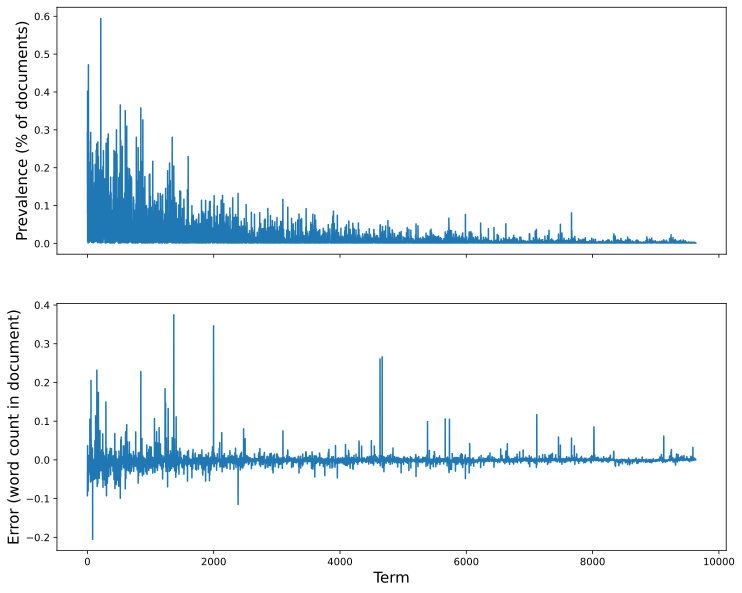

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

sns.lineplot(x=range(len(terms)), y=term_prevalence, ax=axes[0])
axes[0].set_ylabel('Prevalence (% of documents)', fontdict={'size': 15})

sns.lineplot(x=range(len(terms)), y=term_error, ax=axes[1])
axes[1].set_ylabel('Error (word count in document)', fontdict={'size': 15})
axes[1].set_xlabel('Term', fontdict={'size': 15});

So, thought it exists, there really isn't much erroor at all (we're within 1/2 of a count on average, per term), and the bulk of our popular words are at the front end of the corpus. These more prevalent words will have more variability of error, likely explaining the higher magnitude of average error per document.